In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.polynomial import Polynomial

# Setting display options as per your style
pd.set_option('display.precision', 9)
pd.set_option('display.width', 150)

# Adams-Bashforth (Explicit)

## Algorithm

1. Input
    * **System of ODEs:** $\mathbf{Y}' = \mathbf{F}(x, \mathbf{Y})$, where $\mathbf{Y} \in \mathbb{R}^m$
    * **Initial Condition:** $x_0, \mathbf{Y}_0$
    * **Step size:** $h$
    * **Order:** $s$ (requires $s$ historical points)

2. Coefficient Generation ($\beta_j$)

    Compute coefficients $\beta_j$ by integrating Lagrange polynomials over $[0, 1]$:
$$\beta_j = \int_{0}^{1} \prod_{\substack{k=0 \\ k \neq j}}^{s-1} \frac{t + k}{-j + k} \, dt, \quad j = 0, \dots, s-1$$

3. Bootstrapping (Startup):

    Since Adams-Bashforth requires history $\mathbf{F}_{n-1}, \dots, \mathbf{F}_{n-s}$, use a one-step method (Runge-Kutta 4) to compute the first $s$ values:
    $$\mathbf{Y}_1, \mathbf{Y}_2, \dots, \mathbf{Y}_{s-1}$$

    Compute and store derivative vectors:
    $$\mathbf{f}_k = \mathbf{F}(x_k, \mathbf{Y}_k) \quad \text{for } k=0 \dots s-1$$

4. Iteration Loop (for $n \ge s-1$)

    To compute $\mathbf{Y}_{n+1}$:

    1.  **Retrieve History:**
    Get the last $s$ derivative vectors: $[\mathbf{f}_n, \mathbf{f}_{n-1}, \dots, \mathbf{f}_{n-s+1}]$

    2.  **Vector Update:**
    Apply the AB formula (dot product of scalar $\beta$ and vector $\mathbf{f}$):
    $$\mathbf{Y}_{n+1} = \mathbf{Y}_n + h \sum_{j=0}^{s-1} \beta_j \cdot \mathbf{f}_{n-j}$$

    3.  **Update State:**
    $$x_{n+1} = x_n + h$$
    $$\mathbf{f}_{n+1} = \mathbf{F}(x_{n+1}, \mathbf{Y}_{n+1})$$

5. Output
    * Matrix of solution vectors $[\mathbf{Y}_0, \mathbf{Y}_1, \dots, \mathbf{Y}_N]$

In [1]:
# --- 1. Coefficient Generator (Same as before) ---
def get_adams_bashforth_coeffs(s):
    """
    Calculates coeffs beta_j for: Y_{n+1} = Y_n + h * sum(beta_j * F_{n-j})
    Corresponds to integrating nodes 0, -1, ..., -(s-1)
    """
    nodes = -np.arange(s) 
    coeffs = []
    
    for j in range(s):
        roots = []
        denominator = 1.0
        for k in range(s):
            if k == j: continue
            roots.append(nodes[k])
            denominator *= (nodes[j] - nodes[k])
        
        poly_num = Polynomial.fromroots(roots)
        poly_int = poly_num.integ()
        beta_j = (poly_int(1) - poly_int(0)) / denominator
        coeffs.append(beta_j)
        
    return np.array(coeffs)

# --- 2. RK4 Stepper (For Startup) ---
def rk4_step(F, x, Y, h):
    k1 = h * F(x, Y)
    k2 = h * F(x + 0.5*h, Y + 0.5*k1)
    k3 = h * F(x + 0.5*h, Y + 0.5*k2)
    k4 = h * F(x + h, Y + k3)
    return Y + (k1 + 2*k2 + 2*k3 + k4) / 6.0

In [2]:
# --- 3. Vectorized Adams-Bashforth Solver ---
def adams_bashforth_system_solve(F, x0, Y0, h, steps, s):
    """
    Solves a system of ODEs Y' = F(x, Y).
    F: function returning numpy array
    Y0: initial state vector
    """
    # Initialize
    Y0 = np.array(Y0, dtype=float)
    num_vars = len(Y0)
    
    # Generate Coefficients
    betas = get_adams_bashforth_coeffs(s)
    
    # Storage
    # history_f will store [F_{n}, F_{n-1}, ..., F_{n-s+1}]
    # We need a list of history states to bootstrap
    
    results = []
    
    # --- PHASE A: Bootstrapping with RK4 ---
    # We need points 0 to s-1
    x_curr = x0
    y_curr = Y0
    
    # Record Initial
    results.append({'n': 0, 'x': x_curr, 'y': y_curr.copy()})
    
    # We need to store F values for AB
    # Let's store them in a list: [F(0), F(1), ..., F(s-1)]
    f_history = [] 
    f_history.append(F(x_curr, y_curr))
    
    for i in range(1, s):
        y_next = rk4_step(F, x_curr, y_curr, h)
        x_next = x_curr + h
        
        y_curr = y_next
        x_curr = x_next
        
        # Calculate F and store
        f_val = F(x_curr, y_curr)
        f_history.append(f_val)
        
        results.append({'n': i, 'x': x_curr, 'y': y_curr.copy()})

    # At the end of this loop, we are at index s-1 (x_{s-1}).
    # We have f_history containing s vectors: [F_0, ..., F_{s-1}]
    # To predict y_s (index s), we use the AB formula.
    
    # --- PHASE B: Adams-Bashforth Loop ---
    # We loop to find Y_s, Y_{s+1} ... Y_N
    
    for n in range(s, steps + 1):
        # Prepare F matrix for dot product
        # The formula is: Y_n = Y_{n-1} + h * [beta_0*F_{n-1} + beta_1*F_{n-2} ... ]
        # Our f_history list has newest at [-1], oldest at [-s]
        # We need to order them [Newest -> Oldest] to match [beta_0 -> beta_{s-1}]
        
        # Extract last s vectors
        current_f_window = np.array(f_history[-s:]) # Shape (s, num_vars)
        
        # Reverse to match betas (beta0 pairs with F_{n-1}, beta1 with F_{n-2})
        current_f_reversed = current_f_window[::-1] 
        
        # Vectorized Update: Dot product of betas (s,) and F_matrix (s, num_vars)
        # Result is (num_vars,)
        delta_y = h * np.dot(betas, current_f_reversed)
        
        y_next = y_curr + delta_y
        x_next = x_curr + h
        
        # Update State
        y_curr = y_next
        x_curr = x_next
        
        # Compute new F and append to history
        f_val = F(x_curr, y_curr)
        f_history.append(f_val)
        
        results.append({'n': n, 'x': x_curr, 'y': y_curr.copy()})
        
    # Formatting Output
    # Create column names dynamically y0, y1, y2...
    expanded_results = []
    for row in results:
        new_row = {'n': row['n'], 'x': row['x']}
        for i in range(num_vars):
            new_row[f'y{i}'] = row['y'][i]
        expanded_results.append(new_row)
        
    return pd.DataFrame(expanded_results)

## Result

In [6]:
# --- 4. Problem Definition (Example 5.10 from PDF) ---
# L*I'' + R*I' + Q/C = E(t)
# Variables: y0 = Q (Charge), y1 = I (Current)
# System:
# dQ/dt = I  => y0' = y1
# dI/dt = (E(t) - R*I - Q/C) / L => y1' = (E - R*y1 - y0/C) / L

def RLC_Circuit(x, Y):
    Q = Y[0]
    I = Y[1]
    
    # Constants from Example 5.10
    R = 30.0
    L = 2.0
    C = 0.016
    E = 50 * np.cos(10 * x) # E(t)
    
    dQ = I
    dI = (E - R*I - Q/C) / L
    
    return np.array([dQ, dI])

# Parameters
x0 = 0.0
Y0 = [0.0, 0.0] # Q(0)=0, I(0)=0
h = 0.05       # Step size (smaller for stability)
steps = 20
s = 4           # 4-step Adams-Bashforth

In [7]:
betas = get_adams_bashforth_coeffs(s)
betas

array([ 2.29166667, -2.45833333,  1.54166667, -0.375     ])

In [5]:
# Solve
df_system = adams_bashforth_system_solve(RLC_Circuit, x0, Y0, h, steps, s)
df_system

,n,x,y0,y1
0,0,0.00,0.000000000,0.000000000
1,1,0.05,0.024172671,0.823028691
2,2,0.10,0.071151474,0.950281851
3,3,0.15,0.111420260,0.591667716
4,4,0.20,0.125851837,-0.043943583
5,5,0.25,0.105909916,-0.704320568
6,6,0.30,0.058397851,-1.247272229
7,7,0.35,-0.012427109,-1.434238824
8,8,0.40,-0.076923865,-1.368550404
9,9,0.45,-0.140382967,-0.794595233


## Plotting the result

In [8]:
def plot_solver_result(df, mode, col1='x', col2='y_0', output_file='plot.png'):
    """
    Visualizes the solver output.
    
    Parameters:
    df : pd.DataFrame
        The solution table.
    mode : int
        1 for Time Series (x vs y).
        2 for Phase Plot (y_i vs y_j).
    col1 : str
        Name of the column for the X-axis.
    col2 : str
        Name of the column for the Y-axis.
    output_file : str
        Filename to save the image.
    """
    plt.figure(figsize=(10, 6))
    plt.grid(True, linestyle='--', alpha=0.6)
    
    # Plot Logic
    for item in col2:
        plt.plot(df[col1], df[item], label=f'{item} vs {col1}', linewidth=2, )
        plt.xlabel(col1, fontsize=12)
        plt.ylabel(item, fontsize=12)
    # Formatting
    plt.legend()
    
    if mode == 1:
        # Set the axis limits manually
        #plt.xlim(-10, 2000)       # Set x-axis range from 0 to 8
        #plt.ylim(-1.2, 1.2)  # Set y-axis range from -1.2 to 1.2

        plt.title(f"Mode 1: Time Series Plot ({col1} vs {col2})", fontsize=14)

    elif mode == 2:
        # Set the axis limits manually
        #plt.xlim(-10, 250)       # Set x-axis range from 0 to 8
        #plt.ylim(-1.2, 1.2)  # Set y-axis range from -1.2 to 1.2

        plt.title(f"Mode 2: Phase Plane Plot ({col1} vs {col2})", fontsize=14)

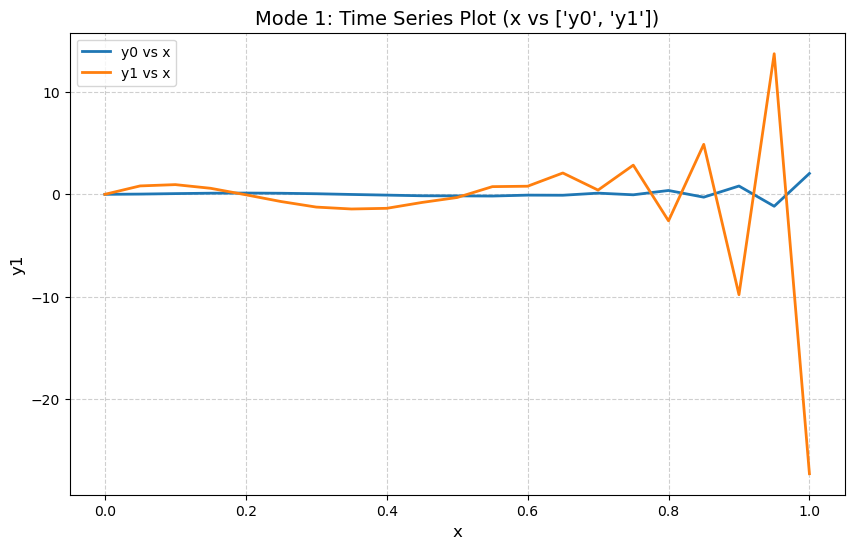

In [9]:
plot_solver_result(df_system, mode=1, col1='x', col2=['y0','y1'])